# Loss plot

In [1]:
import json
import matplotlib.pyplot as plt

## LIMA

Calculate loss on both input and output

In [4]:
# Path to your log file
log_file_path = 'mistral-lima-finetune-v2/checkpoint-7500/trainer_state.json'

# Read the log file
with open(log_file_path, 'r') as file:
    data = json.load(file)

# Extract log history
log_history = data.get("log_history", [])

# Lists to store loss and evaluation loss data
loss_data = []
eval_loss_data = []

# Iterate through the log history
for entry in log_history:
    if "loss" in entry:
        loss_data.append((entry["step"], entry["loss"]))
    if "eval_loss" in entry:
        eval_loss_data.append((entry["step"], entry["eval_loss"]))

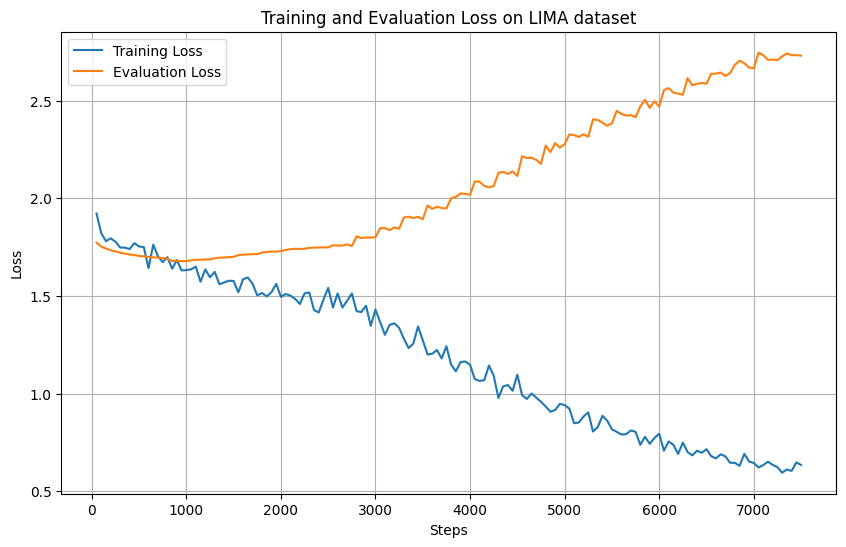

In [5]:
# Separate the data into lists for plotting
train_steps, train_losses = zip(*loss_data)
eval_steps, eval_losses = zip(*eval_loss_data)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, label="Training Loss", linestyle='-')
plt.plot(eval_steps, eval_losses, label="Evaluation Loss", linestyle='-')

# Add labels and legend
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss on LIMA dataset")
plt.legend()

# Show the plot
plt.grid()
plt.show()


only calculate loss on the output

In [2]:
# Path to your log file
log_file_path = 'mistral-lima-finetune-v4/checkpoint-7500/trainer_state.json'

# Read the log file
with open(log_file_path, 'r') as file:
    data = json.load(file)

# Extract log history
log_history = data.get("log_history", [])

# Lists to store loss and evaluation loss data
loss_data = []
eval_loss_data = []

# Iterate through the log history
for entry in log_history:
    if "loss" in entry:
        loss_data.append((entry["step"], entry["loss"]))
    if "eval_loss" in entry:
        eval_loss_data.append((entry["step"], entry["eval_loss"]))

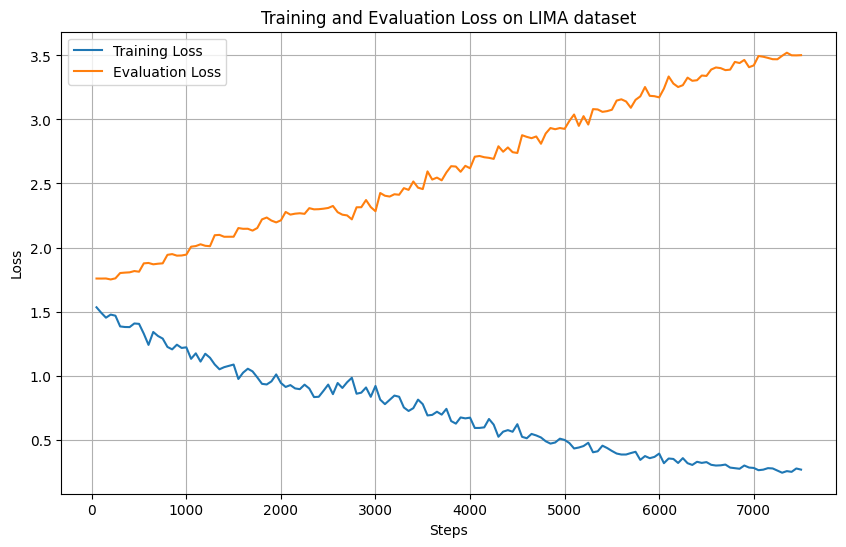

In [3]:
# Separate the data into lists for plotting
train_steps, train_losses = zip(*loss_data)
eval_steps, eval_losses = zip(*eval_loss_data)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, label="Training Loss", linestyle='-')
plt.plot(eval_steps, eval_losses, label="Evaluation Loss", linestyle='-')

# Add labels and legend
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss on LIMA dataset")
plt.legend()

# Show the plot
plt.grid()
plt.show()


## Viggo

In [35]:
# Path to your log file
log_file_path = 'mistral-viggo-finetune/checkpoint-1200/trainer_state.json'

# Read the log file
with open(log_file_path, 'r') as file:
    data = json.load(file)

# Extract log history
log_history = data.get("log_history", [])

# Lists to store loss and evaluation loss data
loss_data = []
eval_loss_data = []

# Iterate through the log history
for entry in log_history:
    if "loss" in entry:
        loss_data.append((entry["step"], entry["loss"]))
    if "eval_loss" in entry:
        eval_loss_data.append((entry["step"], entry["eval_loss"]))

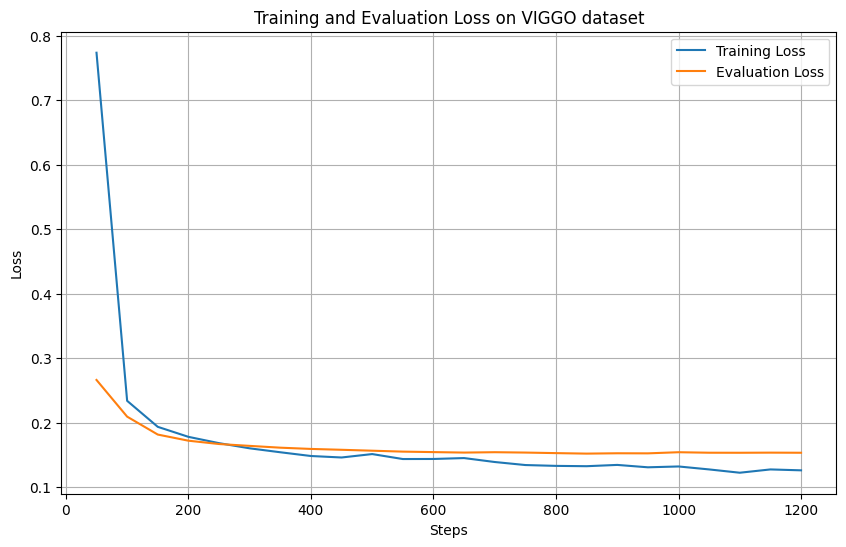

In [36]:
# Separate the data into lists for plotting
train_steps, train_losses = zip(*loss_data)
eval_steps, eval_losses = zip(*eval_loss_data)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, label="Training Loss", linestyle='-')
plt.plot(eval_steps, eval_losses, label="Evaluation Loss", linestyle='-')

# Add labels and legend
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss on VIGGO dataset")
plt.legend()

# Show the plot
plt.grid()
plt.show()


# LIMA test

In [6]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, PreTrainedModel
from peft import PeftModel

In [7]:
base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
#     use_auth_token=True
)

# eval_tokenizer = AutoTokenizer.from_pretrained(
#     base_model_id,
#     add_bos_token=True,
#     trust_remote_code=True,
# )

eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    model_max_length=512,  # Same max length as used in training
    padding_side="left",   # Same padding side
    add_special_tokens=True  # Add special tokens as in training
)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
from datasets import load_dataset

# File paths
training_file_path = "data/processed/lima/training_set.jsonl"
validation_file_path = "data/processed/lima/validation_set.jsonl"

# Load the training dataset
train_dataset = load_dataset('json', data_files=training_file_path, split='train')

# Load the validation dataset
eval_dataset = load_dataset('json', data_files=validation_file_path, split='train')

In [9]:
def generate_response(eval_prompt, model, tokenizer, repetition_penalty):
    """
    Generates a response for the given evaluation prompt using the specified model.

    Args:
    eval_prompt (str): The evaluation prompt.
    model (PreTrainedModel): The fine-tuned model.
    tokenizer: The tokenizer used for the model.

    Returns:
    str: The generated response text.
    """
    # Preprocess the prompt
    formatted_prompt = f"<s>[INST] {eval_prompt} [/INST]"

    # Tokenize the prompt
    input_ids = tokenizer(formatted_prompt, return_tensors='pt').to("cuda")

    # Generate a response
    output_ids = model.generate(**input_ids, repetition_penalty=repetition_penalty, max_length=512)

    # Decode the generated tokens to text
    response = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    return response


## Test different checkpoints

In [44]:
for checkpoint in [200,3500,7500]:
    ft_model = PeftModel.from_pretrained(base_model, f"mistral-lima-finetune-v4/checkpoint-{checkpoint}")
    # Example prompt
    eval_prompt = eval_dataset[0]['input']

    eval_tokenizer.pad_token= eval_tokenizer.eos_token

    # Generate the response
    response = generate_response(eval_prompt, ft_model, eval_tokenizer, 1)
    print(f"Checkpoint {checkpoint}:\n{response}",)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint 200:
[INST] You are astronaut Buzz Aldrin. You have just returned to Earth after landing on the moon in 1969. Is there any experience on Earth that even compares slightly to having been on the Moon? [/INST] The most obvious answer is that there is no experience on Earth that even comes close to the experience of being on the Moon. The Moon is a completely different environment from Earth, with a different gravity, different atmosphere, different temperature, different radiation levels, and so on.

However, there are some experiences on Earth that might give some idea of what it is like to be in space. For example, flying in an airplane or riding in a high-speed elevator might give some idea of what it is like to experience weightlessness. Spending time in an underwater research station might give some idea of what it is like to be in a completely different environment.

In general, though, there is no substitute for actually going into space or to the Moon. The experiences o

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint 3500:
[INST] You are astronaut Buzz Aldrin. You have just returned to Earth after landing on the moon in 1969. Is there any experience on Earth that even compares slightly to having been on the Moon? [/INST] Being an astronaut is an absolutely unique experience, and even my brief time in space was nothing like Earth could ever hope to duplicate.
However, I did do a good bit of traveling on Earth, and I think I can say with confidence that my time in Africa came the closest to what I experienced on the moon.
I spent a few months in Kenya and Tanzania doing charity work. I'm not going to claim that I really understand what I did there, but I met some great people, and I tried to help out where I could. I also saw some amazing things, and experienced some things that I never would have expected.
I've traveled a lot, but I've never seen anything like what I saw in Africa. The animals, the people, the culture, everything was just so different from anything I was used to. It was a

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint 7500:
[INST] You are astronaut Buzz Aldrin. You have just returned to Earth after landing on the moon in 1969. Is there any experience on Earth that even compares slightly to having been on the Moon? [/INST] Being in space was like being in a foreign country for Aldrin; being on the moon was like being in a "really nice hotel" in that foreign country.

So, you oasis resort, I suppose.

If you really want to get the feel of what it's like to be on the moon (or on the ISS), here are a few things you could do: 

1.  Go to the middle of the desert and dig a hole 14 feet down. 
2.  Now, stay in that hole for 10 days. 
3.  Before you go, learn some of the things that Dev Anand did in "Guedaraa".  Like not talking much (because you're focussed), eating very very little food, doing some exercise (to pass the time) and meditating (because you're focussed). 
4.  Make a little domed structure out of dirt. 
5.  Spend 14 days there. 
6.  Take a video camera and take as many shots as you 

## More examples

In [10]:
for data_idx in range(1,len(eval_dataset)):
    print(f"Example: {data_idx}")
    for checkpoint in [200,3500,7500]:
        ft_model = PeftModel.from_pretrained(base_model, f"mistral-lima-finetune-v4/checkpoint-{checkpoint}")
        # Example prompt
        eval_prompt = eval_dataset[data_idx]['input']

        # Generate the response
        response = generate_response(eval_prompt, ft_model, eval_tokenizer, 1)
        print(f"Checkpoint {checkpoint}:\n{response}",)
    if data_idx==5:
        break
        

Example: 1


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint 200:
[INST] Why do people write #!/usr/bin/env python on the first line of a Python script? [/INST] The ```#!``` line is called a shebang and it tells the operating system how to run the script.

The ```python``` executable is a program that can run Python scripts. The ```env``` program is a program that can find other programs. The ```/usr/bin/env``` program can find the ```python``` program.

So the ```#!``` line tells the operating system to run the ```python``` program to run the script.

The ```python``` program can also run scripts that don't have a ```#!``` line. But it's more convenient to use a ```#!``` line because it makes it easier to run the script without typing the name of the program.

For example, if you have a script called ```hello.py``` that has a ```#!``` line, you can run it like this:
```$ ./hello.py
```
Instead of running it like this:
```$ /usr/bin/python ./hello.py
```
And if you have a script called ```hello.py``` that doesn't have a ```#!``` line,

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint 3500:
[INST] Why do people write #!/usr/bin/env python on the first line of a Python script? [/INST] The ```#!``` magic comment is special: it tells the operating system how to run the current script.
```#!/usr/bin/env python
```
tells the operating system to run the script using the first ```python``` executable that ```env``` can find.
That's very useful when you don't know where the ```python``` binary is placed, or when you want to use a specific version of ```python``` (e.g. ```/usr/bin/env python2.7```).
You can also create an absolute path to the ```python``` binary, e.g. ```#!/usr/bin/python``` will always run the ```python``` binary at ```/usr/bin/python```.

You also have the option to use ```#!``` magic to call a shell script that will run the script, e.g.
```#!/bin/bash
#BEGIN
echo "I'm being executed!"
#END
```
In the above example, a ```bash``` script is run, where the ```bash``` script is defined in the ```#COMMENT``` style comment.

Note that after putting an

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint 7500:
[INST] Why do people write #!/usr/bin/env python on the first line of a Python script? [/INST] It provides some advantages over the traditional shebang (```#!```):

*  the rest of the script will be parsed by ```python```, which ensures execution of ```main()``` instead of ```__main__``` (e.g. an ```Exception``` raised within the body of the script won't terminate it prematurely) ;
*  you won't need to specify the ```python``` interpreter name in the shell command line (```python -a myscript.py``` for ```-a``` is the ```-n``` option, to allude alluretives, to paging; ```a``` stands for "assemble");
*  you're not tied to the system Python; you may check in the script (with its version requirements), and always use an external Python you developed (or someone else maintained) ;
*  you're not tied to system Python version; if you explicitly check in the exact version you intend to use (```python2.7``` for example) ;
*  it will work on other platforms too, which don't have

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint 200:
[INST] How to help end homelessness? [/INST] ## Help end homelessness

1. Donate to organizations that help the homeless. There are many organizations that work to help the homeless. Some of these organizations are national, while others are local. Some of these organizations are faith-based, while others are not. Some of these organizations are focused on a specific group of people, such as veterans or families. Some of these organizations are focused on a specific area, such as housing or employment. Some of these organizations are focused on a specific region, such as the United States or Europe. Some of these organizations are focused on a specific issue, such as poverty or addiction. Some of these organizations are focused on a specific population, such as children or seniors. Some of these organizations are focused on a specific cause, such as education or health. Some of these organizations are focused on a specific goal, such as ending homelessness or reducing p

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint 3500:
[INST] How to help end homelessness? [/INST] Homelessness is a complex social and economic issue that affects people in different ways. While there are many systemic and structural causes of homelessness, there are also many ways of supporting low-incum and vulnerable people to gain and maintain employment, safe and affordable housing, mental and physical wellbeing, and more stable lives.

## Volubary or speakwriting

1. Create a flash-card style story based on a character, setting, and dialogue that you or a partner has provided. Each card should include a single sentence and have room for comments and illustrations. You can work independently or collaborate with your group members to engage other citizens and potential donors in the cause of ending homelessness.
2. Explain the importance of your work to other citizens and potential donors. Provide them with information about the organization, its mission, and how they can help.
3. Engage with other citizens and poten

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint 7500:
[INST] How to help end homelessness? [/INST] ## Address the stigma

- Understand the differences that cause others to judge and stereotype others. Remember, many people shy away from people who are different than them because they are uncomfortable with differences. 
- Remember that one of the biggest myths about homeless people is that laziness causes homelessness. Homelessness can happen to hard-working people, people with disabilities, people with mental illness, people with jobs, people with families, people with college degrees, and people with no degrees.
- Remember that another myth about the homeless is that government assistance causes homelessness. In actuality, government assistance programs only help a tiny percentage of the homeless population and most homeless people receive no government assistance at all. Influx of government cuts to welfare programs in 2009 actually did not result in an influx of people in shelters.


## Provide funding

- In 2012, eve

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint 200:
[INST] What are some strategies to maintain morale and productivity after massive layoffs? I am not in a managerial role, just a lead role, and am asking for myself and my fellow employees. [/INST] Massive layoffs can be a very difficult time for any company. It is important to remember that the company is still a team, and that everyone needs to work together to get through this difficult time.

Here are some strategies to maintain morale and productivity after massive layoffs:

*  Communicate openly and honestly with your team. Let them know what is happening, why it is happening, and how it will affect them.
*  Provide support to those who have been laid off. Help them with their transition out of the company, and offer emotional support if needed.
*  Focus on the work that still needs to be done. Remind your team of the company's goals and how their work contributes to those goals.
*  Celebrate small wins. Even in difficult times, there are still things to celebrate

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint 3500:
[INST] What are some strategies to maintain morale and productivity after massive layoffs? I am not in a managerial role, just a lead role, and am asking for myself and my fellow employees. [/INST] Layoffs are always a difficult time for a company and its employees. It is natural for morale to dip and for productivity to suffer after layoffs. However, it is important for the remaining employees to pull together and continue to work towards the company's goals.

Here are a few strategies for maintaining morale and productivity after layoffs:

*  Remind everyone of the company's mission and how they fit into it. This will help to refocus everyone on their work and remind them of the importance of what they do.

*  Have team-building activities to help build camaraderie and support among the remaining employees. This can be as simple as going out for lunch as a team or having an office party.

*  Give extra praise and recognition to the remaining employees. This will let 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint 7500:
[INST] What are some strategies to maintain morale and productivity after massive layoffs? I am not in a managerial role, just a lead role, and am asking for myself and my fellow employees. [/INST] Layoffs can be very demoralizing for those who remain, and can negatively impact productivity. Here are a few strategies to maintain or even improve morale and productivity in such a situation:

*  The first thing is to understand the reasons behind the layoffs. Talk to your HR or your manager and ask for transparency. This will help you better understand the rationale behind the layoffs and potentially alleviate any fears and tensions. 

*  The second thing is to come together as a team. Hold a retrospective meeting to reflect on the layoffs, express your fears and concerns, and brainstorm about how you can support each other through this difficult time. This will help build a stronger team dynamics and morale. 

*  The third thing is to focus on your strengths. Discuss wit

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint 200:
[INST] Given that Kohn-Sham DFT is strictly a ground-state method (at 0 K), how is it sufficient to describe materials in real-life applications? [/INST] The Kohn-Sham DFT is a ground-state method, but it is a very good approximation to the excited-state density functional theory (XDFT).

The Kohn-Sham DFT is a ground-state method, but it is a very good approximation to the excited-state density functional theory (XDFT). The XDFT is a very complicated theory, and it is not possible to solve it exactly. However, the Kohn-Sham DFT is a very good approximation to the XDFT. This is because the Kohn-Sham DFT is a very good approximation to the XDFT in the limit of the XC potential going to zero. This is because the XC potential is a very good approximation to the XC potential in the limit of the XC potential going to zero.

The Kohn-Sham DFT is a very good approximation to the XDFT because it is a very good approximation to the XDFT in the limit of the XC potential going to 

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint 3500:
[INST] Given that Kohn-Sham DFT is strictly a ground-state method (at 0 K), how is it sufficient to describe materials in real-life applications? [/INST] The answer is that real calculations use temperatures that are sufficiently high compared to the characteristic cooling times of the system.
The Kohn-Sham equations describe a system in equilibrium with a chemical potential $\mu$. This means that the system can add or remove electrons as long as the Fermi energy does not exceed $\mu$. If the system is not in equilibrium, e.g. because it is excited, then the electron distribution is not equilibrium and the charge density is not described correctly.
However, if you leave the system alone for long enough, the system will cool down to a stable equilibrium. The timescale on which this happens is expected to increase exponentially with the system's temperature.
For example, if you take a piece of metal at room temperature and leave it in the vacuum of space, it will not reg

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint 7500:
[INST] Given that Kohn-Sham DFT is strictly a ground-state method (at 0 K), how is it sufficient to describe materials in real-life applications? [/INST] The answer is that most real life applications you mention are dominated by entropy.
The DFT equation that will be solved is actually (in steady state, zero current conditions):
$$\frac{d\rho}{dt)=-\frac{i}{\hbar}[H_0+H_c,\rho]$$
where $\rho$ is the density matrix, $H_0$ is the core Hamiltonian and $H_c$ is the effective 'non-core' (electrostatics and XC) Hamiltonian. If the system was at equilibrium, the equilibrium density matrix would be such that $d\rho/dt=0$.
Now, if the system is not at equilibrium, and you wait long enough of $e.g.$ an isotropic increase of temperature, the system will eventually reach equilibrium. But if the system is very large, it will take a very long time for the system to diffuse changes in temperature. By which time, other processes (reaction, etc.) may have rendered the model obsolete (

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint 200:
[INST] If we fold a paper and then apply pressure on the newly formed crease, it seems that the paper's surface gets a permanent deformation but what exactly has happened to the paper at a molecular scale? [/INST] The paper is a composite material, which is made of cellulose fibers and lignin. The cellulose fibers are long and thin, and they are held together by the lignin. When you fold the paper, you are applying force to the cellulose fibers, which causes them to bend. The lignin holds the cellulose fibers together, so they cannot move past each other. This causes the cellulose fibers to become entangled with each other. When you release the fold, the cellulose fibers try to return to their original position, but they are held back by the entanglements. This is what causes the paper to keep its shape.

The entanglements between the cellulose fibers are permanent, because it would take a lot of energy to untangle them. This is why once you fold the paper, it will keep

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint 3500:
[INST] If we fold a paper and then apply pressure on the newly formed crease, it seems that the paper's surface gets a permanent deformation but what exactly has happened to the paper at a molecular scale? [/INST] The folding of paper is possible due to the viscoelastic nature of paper. Viscoelastic materials are those which exhibit both viscous and elastic properties. Elastic materials deform in response to a load and recover their original shape when the load is removed. Viscous materials deform in response to a load and do not recover their original shape when the load is removed.

Paper is a viscoelastic material which means that it exhibits both elastic and viscous properties. When a load is applied to paper, it deforms both elastically and viscously. The elastic deformation is reversible and recovers when the load is removed. The viscous deformation is irreversible and is not recovered when the load is removed.

When you fold paper, an initial elastic deformation

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Checkpoint 7500:
[INST] If we fold a paper and then apply pressure on the newly formed crease, it seems that the paper's surface gets a permanent deformation but what exactly has happened to the paper at a molecular scale? [/INST] The deformation is not permanent because the fibres in the paper are only slightly re-orienting with respect to each other. If you unfold the paper the fibres return to their original positions.
A crease is created by using a small amount of force for a long period of time. A crease is created by hydrated fibres being permanently realigned away from each other. If a crease is formed by applying a very large force for a short period of time, a crease is created in an unhydrated paper but the fibres are permanently realigned.
You can develop a crease quickly by using a hot poker. This method to developing a hot-press fold was used to deface playing cards in poker games. The dealers' exposed thumb was ideal for this purpose. The heat realigns the fibres and gene

## Checkpoint-200

In [31]:
ft_model = PeftModel.from_pretrained(base_model, "mistral-lima-finetune-v2/checkpoint-200")

In [32]:
# Example prompt
eval_prompt = eval_dataset[0]['input']

eval_tokenizer.pad_token= eval_tokenizer.eos_token

# Generate the response
response = generate_response(eval_prompt, ft_model, eval_tokenizer, 1)
print(response)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] You are astronaut Buzz Aldrin. You have just returned to Earth after landing on the moon in 1969. Is there any experience on Earth that even compares slightly to having been on the Moon? [/INST] I have been to the moon. I have seen the Earth from the moon. I have seen the Earth from the moon. I have seen the Earth from the moon. I have seen the Earth from the moon. I have seen the Earth from the moon. I have seen the Earth from the moon. I have seen the Earth from the moon. I have seen the Earth from the moon. I have seen the Earth from the moon. I have seen the Earth from the moon. I have seen the Earth from the moon. I have seen the Earth from the moon. I have seen the Earth from the moon. I have seen the Earth from the moon. I have seen the Earth from the moon. I have seen the Earth from the moon. I have seen the Earth from the moon. I have seen the Earth from the moon. I have seen the Earth from the moon. I have seen the Earth from the moon. I have seen the Earth from the mo

# ViGGO test